##### import statements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

##### read input csv

In [3]:
df = pd.read_csv( "data/result/source_price.csv").drop( "Unnamed: 0", axis=1)

##### Differential Privacy (Add Noise)

In [4]:
wsj_var = np.var( df[ "wsj_mean_compound"])
cnbc_var = np.var( df[ "cnbc_mean_compound"])
fortune_var = np.var( df[ "fortune_mean_compound"])
reuters_var = np.var( df[ "reuters_mean_compound"])

MU = 0
NOISE = 0.1

sigma_wsj = NOISE * wsj_var
sigma_cnbc = NOISE * cnbc_var
sigma_fortune = NOISE * fortune_var
sigma_reuters = NOISE * reuters_var

wsj_noise = []
cnbc_noise = []
fortune_noise = []
reuters_noise = []

for i in range( len( df)):
    wsj_noise.append( df[ "wsj_mean_compound"][ i] + np.random.normal( MU, sigma_wsj))
    cnbc_noise.append( df[ "cnbc_mean_compound"][ i] + np.random.normal( MU, sigma_cnbc))
    fortune_noise.append( df[ "fortune_mean_compound"][ i] + np.random.normal( MU, sigma_fortune))
    reuters_noise.append( df[ "reuters_mean_compound"][ i] + np.random.normal( MU, sigma_reuters))

df[ "wsj_noise"] = wsj_noise
df[ "cnbc_noise"] = cnbc_noise
df[ "fortune_noise"] = fortune_noise
df[ "reuters_noise"] = reuters_noise

df1 = pd.DataFrame()
df1[ "price"] = df[ "Adj Close"]
df1[ "wsj"] = df[ "wsj_noise"]
df1[ "cnbc"] = df[ "cnbc_mean_compound"]
df1[ "fortune"] = df[ "fortune_mean_compound"]
df1[ "reuters"] = df[ "reuters_mean_compound"]

df2 = pd.DataFrame()
df2[ "price"] = df[ "Adj Close"]
df2[ "wsj"] = df[ "wsj_mean_compound"]
df2[ "cnbc"] = df[ "cnbc_noise"]
df2[ "fortune"] = df[ "fortune_mean_compound"]
df2[ "reuters"] = df[ "reuters_mean_compound"]

df3 = pd.DataFrame()
df3[ "price"] = df[ "Adj Close"]
df3[ "wsj"] = df[ "wsj_mean_compound"]
df3[ "cnbc"] = df[ "cnbc_mean_compound"]
df3[ "fortune"] = df[ "fortune_noise"]
df3[ "reuters"] = df[ "reuters_mean_compound"]

df4 = pd.DataFrame()
df4[ "price"] = df[ "Adj Close"]
df4[ "wsj"] = df[ "wsj_mean_compound"]
df4[ "cnbc"] = df[ "cnbc_mean_compound"]
df4[ "fortune"] = df[ "fortune_mean_compound"]
df4[ "reuters"] = df[ "reuters_noise"]

##### static variables

In [5]:
SPLIT = 0.85
SEQUENCE_LENGTH = 10
BATCH_SIZE = 100
INPUT_DIM = 5
INPUT_TIMESTEPS = 9
NEURONS = 50
EPOCHS = 5
PREDICTION_LENGTH = 1
DENSE_OUTPUT = 1
DROPOUT = 0.2

##### create window data

In [6]:
def create_win_data( data, sequence_length):
    len_data = len( data)

    data_windows = []
    for i in range( len_data - sequence_length):
        data_windows.append( data[ i:i + sequence_length])

    return np.array( data_windows).astype( float)

##### normalize data

In [7]:
def normalize( data_windows):
    normalized_data = []
    record_min = []
    record_max = []

    for i in range( len( data_windows)):
        t = data_windows[ i, :, 0]

        minimum = t.min()
        record_min.append( minimum)

        maximum = t.max()
        record_max.append( maximum)

        diff = maximum - minimum

        t = t - minimum
        t = t / diff

        data_windows[ i, :, 0] = t

        normalized_data.append( data_windows[ i])

    record_min = np.array( record_min)
    record_max = np.array( record_max)
    normalized_data = np.array( normalized_data)

    return normalized_data, record_min, record_max


##### features and labels

In [8]:
def input_label( data):
    x = data[ :, :-1]
    y = data[ :, -1, [ 0]]

    return x, y

##### train & test split info

In [9]:
i_split = int( len( df) * SPLIT)

##### prepare train data

In [10]:
cols = [ "price", "wsj", "cnbc", "fortune", "reuters"]

data_train1 = df1[ cols].values[ :i_split]
data_train2 = df2[ cols].values[ :i_split]
data_train3 = df3[ cols].values[ :i_split]
data_train4 = df4[ cols].values[ :i_split]

train_data1_windows = create_win_data( data_train1, SEQUENCE_LENGTH)
normalized_train_data1, record_min_train1, record_max_train1 = normalize( train_data1_windows)
x_train1, y_train1 = input_label( normalized_train_data1)

train_data2_windows = create_win_data( data_train2, SEQUENCE_LENGTH)
normalized_train_data2, record_min_train2, record_max_train2 = normalize( train_data2_windows)
x_train2, y_train2 = input_label( normalized_train_data2)

train_data3_windows = create_win_data( data_train3, SEQUENCE_LENGTH)
normalized_train_data3, record_min_train3, record_max_train3 = normalize( train_data3_windows)
x_train3, y_train3 = input_label( normalized_train_data3)

train_data4_windows = create_win_data( data_train4, SEQUENCE_LENGTH)
normalized_train_data4, record_min_train4, record_max_train4 = normalize( train_data4_windows)
x_train4, y_train4 = input_label( normalized_train_data4)

x_train = np.concatenate( ( x_train1, x_train2, x_train3, x_train4), axis=0)
y_train = np.concatenate( ( y_train1, y_train2, y_train3, y_train4), axis=0)

print( f"x_train Shape: { x_train.shape}, y_train Shape: { y_train.shape}")

x_train Shape: (368, 9, 5), y_train Shape: (368, 1)


##### prepare test data

In [11]:
data_test = df[ [ "Adj Close", "wsj_mean_compound", "cnbc_mean_compound", "fortune_mean_compound", "reuters_mean_compound"]].values[ i_split:]

test_data_windows = create_win_data( data_test, SEQUENCE_LENGTH)
normalized_test_data, record_min_test, record_max_test = normalize( test_data_windows)
x_test, y_test = input_label( normalized_test_data)

print( f"x_test Shape: { x_test.shape}, y_train Shape: { y_test.shape}")

x_test Shape: (9, 9, 5), y_train Shape: (9, 1)


##### create model

In [12]:
model = tf.keras.models.Sequential( [
    tf.keras.layers.LSTM( NEURONS, input_shape=( INPUT_TIMESTEPS, INPUT_DIM), return_sequences=True),
    tf.keras.layers.Dropout( DROPOUT),
    tf.keras.layers.LSTM( NEURONS, return_sequences=True),
    tf.keras.layers.LSTM( NEURONS, return_sequences=False),
    tf.keras.layers.Dropout( DROPOUT),
    tf.keras.layers.Dense( DENSE_OUTPUT, activation="linear")
])

model.compile(
    loss="mse",
    optimizer="adam"
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 50)             11200     
                                                                 
 dropout (Dropout)           (None, 9, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 9, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51651 (201.76 KB)
Trainable params: 51651 

##### train model

In [13]:
history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/5
4/4 [==============================] - 18s 49ms/step - loss: 0.4503
Epoch 2/5
4/4 [==============================] - 0s 47ms/step - loss: 0.3510
Epoch 3/5
4/4 [==============================] - 0s 78ms/step - loss: 0.2444
Epoch 4/5
4/4 [==============================] - 0s 52ms/step - loss: 0.2193
Epoch 5/5
4/4 [==============================] - 0s 50ms/step - loss: 0.1939


##### plot loss

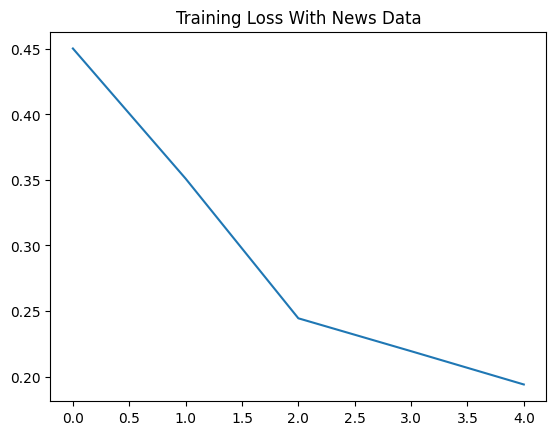

In [14]:
plt.figure()
plt.plot( history.history[ "loss"], label="Loss")
plt.title( "Training Loss With News Data")
plt.show()

##### denormalize data

In [15]:
def denormalize( data, record_min, record_max):
    denormalized = []
    for i in range( len( data)):
        minimum = record_min[ i]
        maximum = record_max[ i]
        diff = maximum - minimum
        denormalized.append( data[ i] * diff + minimum)

    return np.array( denormalized)

##### predict all data

In [16]:
all_data_windows = create_win_data( df[ [ "Adj Close", "wsj_mean_compound", "cnbc_mean_compound", "fortune_mean_compound", "reuters_mean_compound"]].values, SEQUENCE_LENGTH)
normalized_all_data, record_min_all, record_max_all = normalize( all_data_windows)
x_all, y_all = input_label( normalized_all_data)

In [17]:
y_all_pred = model.predict( x_all)

4/4 [==============================] - 4s 8ms/step


In [18]:
y_all_pred_denormalized = denormalize( y_all_pred, record_min_all, record_max_all)

np.save( "data/result/dp-lstm_with_news_on_sp500_denormalized_all.npy", y_all_pred_denormalized)

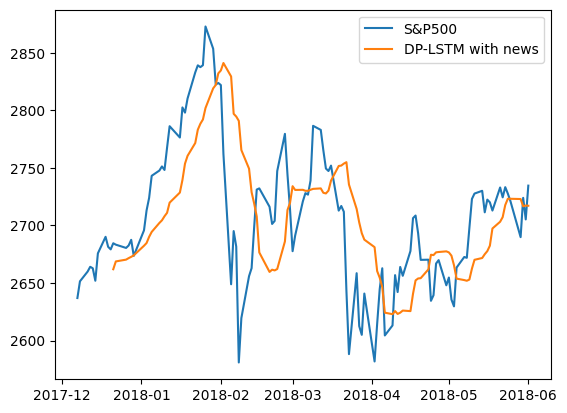

In [19]:
x = [ datetime.strptime( d, "%Y-%m-%d") for d in df[ "date"].values]

plt.figure()
plt.plot( x, df[ "Adj Close"].values, label="S&P500")
plt.plot( x[ 10:], y_all_pred_denormalized, label="DP-LSTM with news")
plt.legend()
plt.show()

##### predict test data

In [20]:
prediction_sequence = []
prediction_window_numbers = int( len( x_test) / PREDICTION_LENGTH)

for i in range( prediction_window_numbers):
    current_frame = x_test[ i * PREDICTION_LENGTH]
    predicted = []
    for j in range( PREDICTION_LENGTH):
        t = model.predict( current_frame[ np.newaxis, :])[ 0]
        predicted.append( t)
        current_frame = current_frame[ 1:]
        current_frame = np.insert( current_frame, [ SEQUENCE_LENGTH - 2], predicted[ -1], axis=0)
    prediction_sequence.append( predicted)

prediction_sequence = np.array( prediction_sequence)

1/1 [==============================] - 0s 36ms/step


##### test label original (denormalized)

In [21]:
y_test_orig = denormalize( y_test, record_min_test, record_max_test)

##### denormalize predicted labels

In [22]:
y_pred_denormalized = denormalize( prediction_sequence.flatten(), record_min_test, record_max_test)

##### evaluation

In [23]:
error = []
squared_error = []
abs_error = []
error_percent = []

for i in range( len( y_test_orig)):
    e = y_test_orig[ i] - y_pred_denormalized[ i]
    error.append( e)
    squared_error.append( e ** 2)
    abs_error.append( np.abs( e))
    error_percent.append( np.abs( e) / y_test_orig[ i])

mean_percent_error = np.sum( error_percent) / len( error_percent)
accuracy = 1 - mean_percent_error

MSE = np.sum( squared_error) / len( squared_error)

print( f"MSE: { MSE}")
print( f"Accuracy: { accuracy}")
print( f"Mean Error Percent: { mean_percent_error}")

MSE: 203.72884638930137
Accuracy: 0.9957486137801178
Mean Error Percent: 0.004251386219882144
